# Data Science Nanodegree - Udacity
* Author: Matthias Schroeder
* Date: 18.04.2020
* data set: WHO life expectancy: https://www.kaggle.com/kumarajarshi/life-expectancy-who

In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt

#from IPython import display
from IPython.display import Image  
import pydotplus

# Import ML librariers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.externals.six import StringIO  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
# Read data
df = pd.read_csv('data_in/Life Expectancy Data.csv')
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


### Fix meta data

In [3]:
# Remove leading & tailing whitespaces from column names
df.rename(columns=lambda col: col.strip(), inplace=True)

In [4]:
# DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [24]:
# Investigate missings
def scan_missings(df):
    '''
    INPUT
        pandas DataFrame - complete pandas dataframe, which should be tested for missing values
    
    OUTPUT
        return pandas DataFrame - showing information for each column of the input DF about sum of missings, ratio of missings
        return list - contains names of columns with missing values
    
    '''
    cols_missings = df.columns[df.isnull().any()].tolist()
    df_info = pd.DataFrame({'sum_missing': df.isnull().sum(), 'rat_missing':df.isnull().mean()}).sort_values(by=['rat_missing'], ascending=False)
    
    return df_info, cols_missings


def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator

def quantile_at(y):
    '''
    INPUT
        float - float representing a desired percentile of an statistical aggregation function
    
    OUTPUT
        return float - result of the given input values and the calculated desired percentile.

    '''
    @rename(f'q{y:0.2f}')
    def q(x):
        return x.quantile(y)
    return q

### Impute Missing Values

In [25]:
# print DataFrame info w/ missing value info
df_info_missing, cols_missings = scan_missings(df)
print('DataFrame info\n\trows:', df.shape[0], '\n\tcolumns:', df.shape[1])
print('\tcolumns w/ missings:',len(cols_missings), cols_missings)

DataFrame info
	rows: 2938 
	columns: 22
	columns w/ missings: 14 ['Life expectancy', 'Adult Mortality', 'Alcohol', 'Hepatitis B', 'BMI', 'Polio', 'Total expenditure', 'Diphtheria', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling']


#### Remove observations w/ missing _Life expactancy_

In [26]:
# Remove all values w/ Life expectancy missing
df_prep = df.dropna(subset=['Life expectancy'])

# print DataFrame info w/ missing value info
df_info_missing, cols_missings = scan_missings(df_prep)
print('DataFrame info\n\trows:', df_prep.shape[0], '\n\tcolumns:', df_prep.shape[1])
print('\tcolumns w/ missings:',len(cols_missings), cols_missings)
print(df_info_missing)

DataFrame info
	rows: 2928 
	columns: 22
	columns w/ missings: 12 ['Alcohol', 'Hepatitis B', 'BMI', 'Polio', 'Total expenditure', 'Diphtheria', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling']
                                 sum_missing  rat_missing
Population                               644     0.219945
Hepatitis B                              553     0.188866
GDP                                      443     0.151298
Total expenditure                        226     0.077186
Alcohol                                  193     0.065915
Schooling                                160     0.054645
Income composition of resources          160     0.054645
thinness 5-9 years                        32     0.010929
thinness  1-19 years                      32     0.010929
BMI                                       32     0.010929
Diphtheria                                19     0.006489
Polio                                     19 

#### replace w/ **mean - over all observations** in numeric columns

In [27]:
# Add missing indicator column
def get_missingIndicator(df):
    '''
    INPUT
        pandas DataFrame - pandas DataFrame containing missing values
    
    OUTPUT
        pandas DataFrame - original DataFrame including added missing indicator columns
    
    '''
    from sklearn.impute import MissingIndicator
    
    indicator = MissingIndicator()
    indicator.fit(df)
    np_indicator = indicator.transform(df_prep)
    cols_indicator = [c + '_NA' for c in df_prep.columns[indicator.features_]]
    df = df.join(pd.DataFrame(np_indicator, columns=cols_indicator)).copy()
    
    return df


df_prep = get_missingIndicator(df_prep)

In [28]:
# fill mean (over all observations)
fill_mean = lambda col: col.fillna(col.mean())
df_prep = pd.concat([df_prep.drop(cols_missings, axis=1), df_prep[cols_missings].apply(fill_mean, axis=0)], axis=1)

In [29]:
# print DataFrame info w/ missing value info
df_info_missing, cols_missings = scan_missings(df_prep)
print('DataFrame info\n\trows:', df_prep.shape[0], '\n\tcolumns:', df_prep.shape[1])
print('\tcolumns w/ missings:',len(cols_missings), cols_missings)
#print(df_info_missing)

DataFrame info
	rows: 2928 
	columns: 34
	columns w/ missings: 12 ['Alcohol_NA', 'Hepatitis B_NA', 'BMI_NA', 'Polio_NA', 'Total expenditure_NA', 'Diphtheria_NA', 'GDP_NA', 'Population_NA', 'thinness  1-19 years_NA', 'thinness 5-9 years_NA', 'Income composition of resources_NA', 'Schooling_NA']


In [31]:
df = df_prep.copy()

## Data Exploration

In [32]:
df.head(10)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,percentage expenditure,Measles,under-five deaths,HIV/AIDS,...,BMI,Polio,Total expenditure,Diphtheria,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,71.279624,1154,83,0.1,...,19.1,6.0,8.16,65.0,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,73.523582,492,86,0.1,...,18.6,58.0,8.18,62.0,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,73.219243,430,89,0.1,...,18.1,62.0,8.13,64.0,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,78.184215,2787,93,0.1,...,17.6,67.0,8.52,67.0,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,7.097109,3013,97,0.1,...,17.2,68.0,7.87,68.0,63.537231,2978599.0,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279.0,74,79.679367,1989,102,0.1,...,16.7,66.0,9.20,66.0,553.328940,2883167.0,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281.0,77,56.762217,2861,106,0.1,...,16.2,63.0,9.42,63.0,445.893298,284331.0,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287.0,80,25.873925,1599,110,0.1,...,15.7,64.0,8.33,64.0,373.361116,2729431.0,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295.0,82,10.910156,1141,113,0.1,...,15.2,63.0,6.73,63.0,369.835796,26616792.0,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295.0,84,17.171518,1990,116,0.1,...,14.7,58.0,7.43,58.0,272.563770,2589345.0,19.2,19.3,0.405,8.1


In [33]:
# Number of countries
print('# countries:', df['Country'].nunique())
print('# countries per Status:', df.groupby(['Status'])['Country'].nunique())
print('# years of observation:', df['Year'].nunique())

# countries: 183
# countries per Status: Status
Developed      32
Developing    151
Name: Country, dtype: int64
# years of observation: 16


In [34]:
# Aggregating the Countries over years
df_mean = df.groupby(['Country','Status'])[df.select_dtypes(['float64','int64']).drop('Year', axis=1).columns].mean().reset_index()
df_mean.columns = ['{}{}'.format(c, '' if c in ['Country','Status'] else '_mean') for c in df_mean.columns]
print('rows:',df_mean.shape[0], 'columns:', df_mean.shape[1])
df_mean.head()

rows: 183 columns: 21


,Country,Status,Life expectancy_mean,Adult Mortality_mean,infant deaths_mean,percentage expenditure_mean,Measles_mean,under-five deaths_mean,HIV/AIDS_mean,Alcohol_mean,...,BMI_mean,Polio_mean,Total expenditure_mean,Diphtheria_mean,GDP_mean,Population_mean,thinness 1-19 years_mean,thinness 5-9 years_mean,Income composition of resources_mean,Schooling_mean
0,Afghanistan,Developing,58.19375,269.0625,78.2500,34.960110,2362.2500,107.5625,0.10000,0.014375,...,15.51875,48.3750,8.252500,52.3125,340.015425,9.972260e+06,16.58125,15.58125,0.415375,8.21250
1,Albania,Developing,75.15625,45.0625,0.6875,193.259091,53.3750,0.9375,0.10000,4.848750,...,49.06875,98.1250,5.945625,98.0625,2119.726679,6.969116e+05,1.61875,1.70000,0.709875,12.13750
2,Algeria,Developing,73.61875,108.1875,20.3125,236.185241,1943.8750,23.5000,0.10000,0.669678,...,48.74375,91.7500,4.686885,91.8750,2847.853392,2.164983e+07,6.09375,5.97500,0.694875,12.71250
3,Angola,Developing,49.01875,328.5625,83.7500,102.100268,3561.3125,132.6250,2.36875,5.670303,...,18.01875,46.1250,4.045010,47.6875,1975.143045,1.014710e+07,6.19375,6.66875,0.458375,8.04375
4,Antigua and Barbuda,Developing,75.05625,127.5000,0.0000,1001.585226,0.0000,0.0000,0.12500,7.740928,...,38.42500,96.9375,4.862510,98.3125,9759.305728,1.276454e+07,3.42500,3.37500,0.488625,8.84375


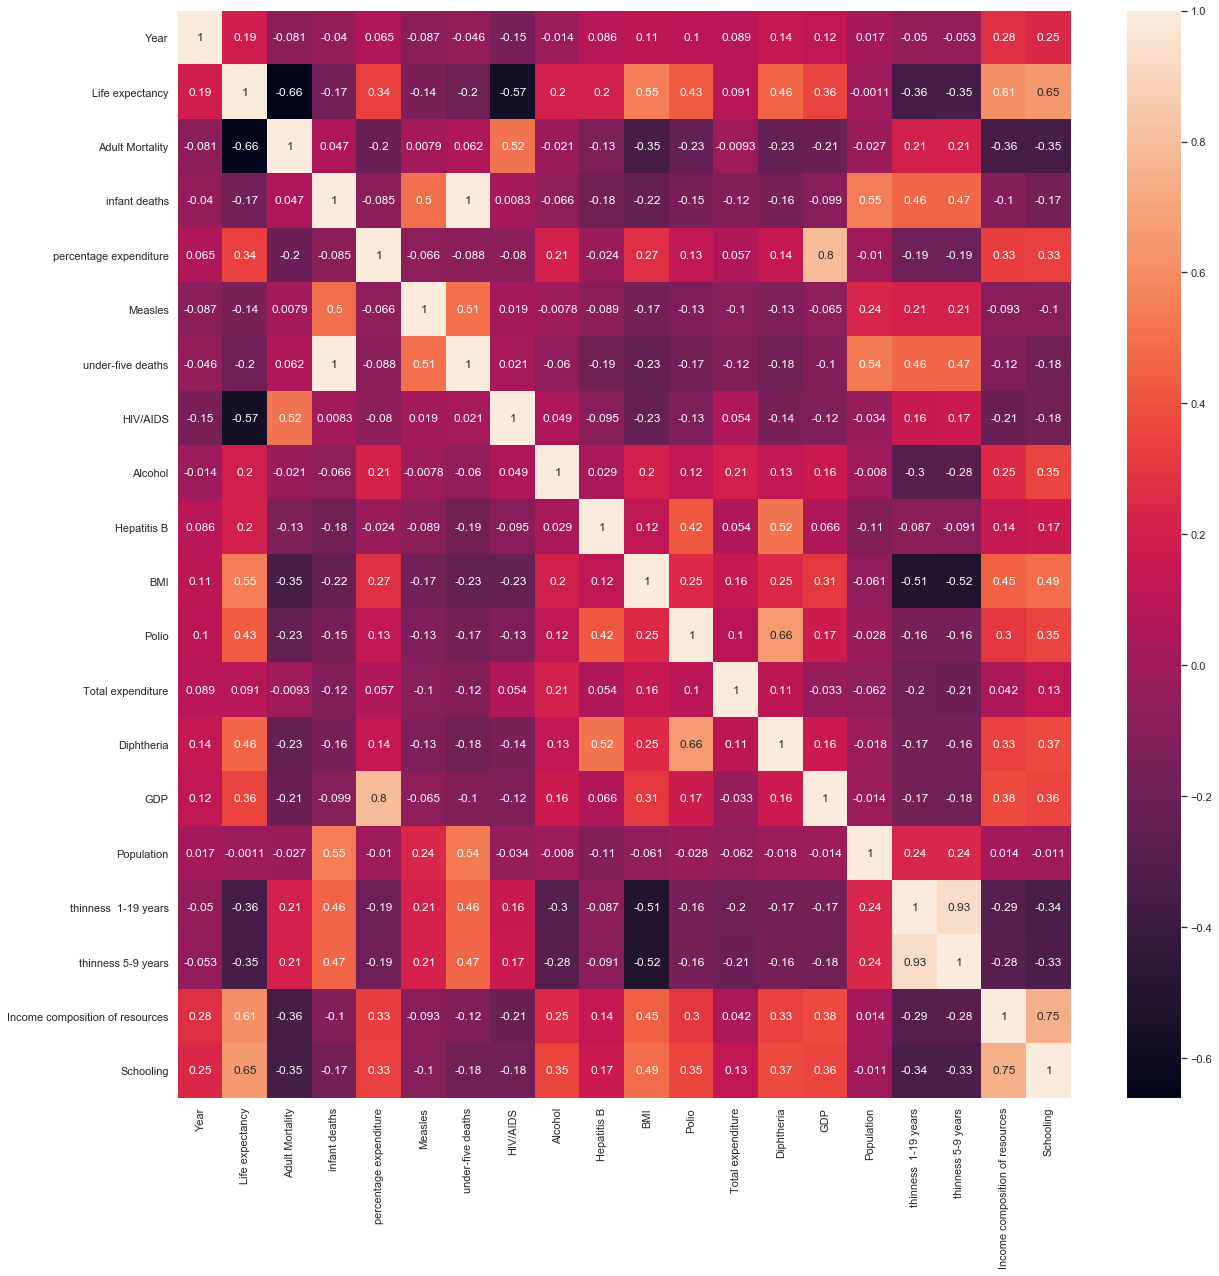

In [35]:
# Correlation matrix of developing countries
sns.set(style='whitegrid')
cfg_figsize = (20, 20)
fig, ax = plt.subplots(figsize=cfg_figsize)
sns.heatmap(df[df['Status']=='Developing'].corr(), annot=True)

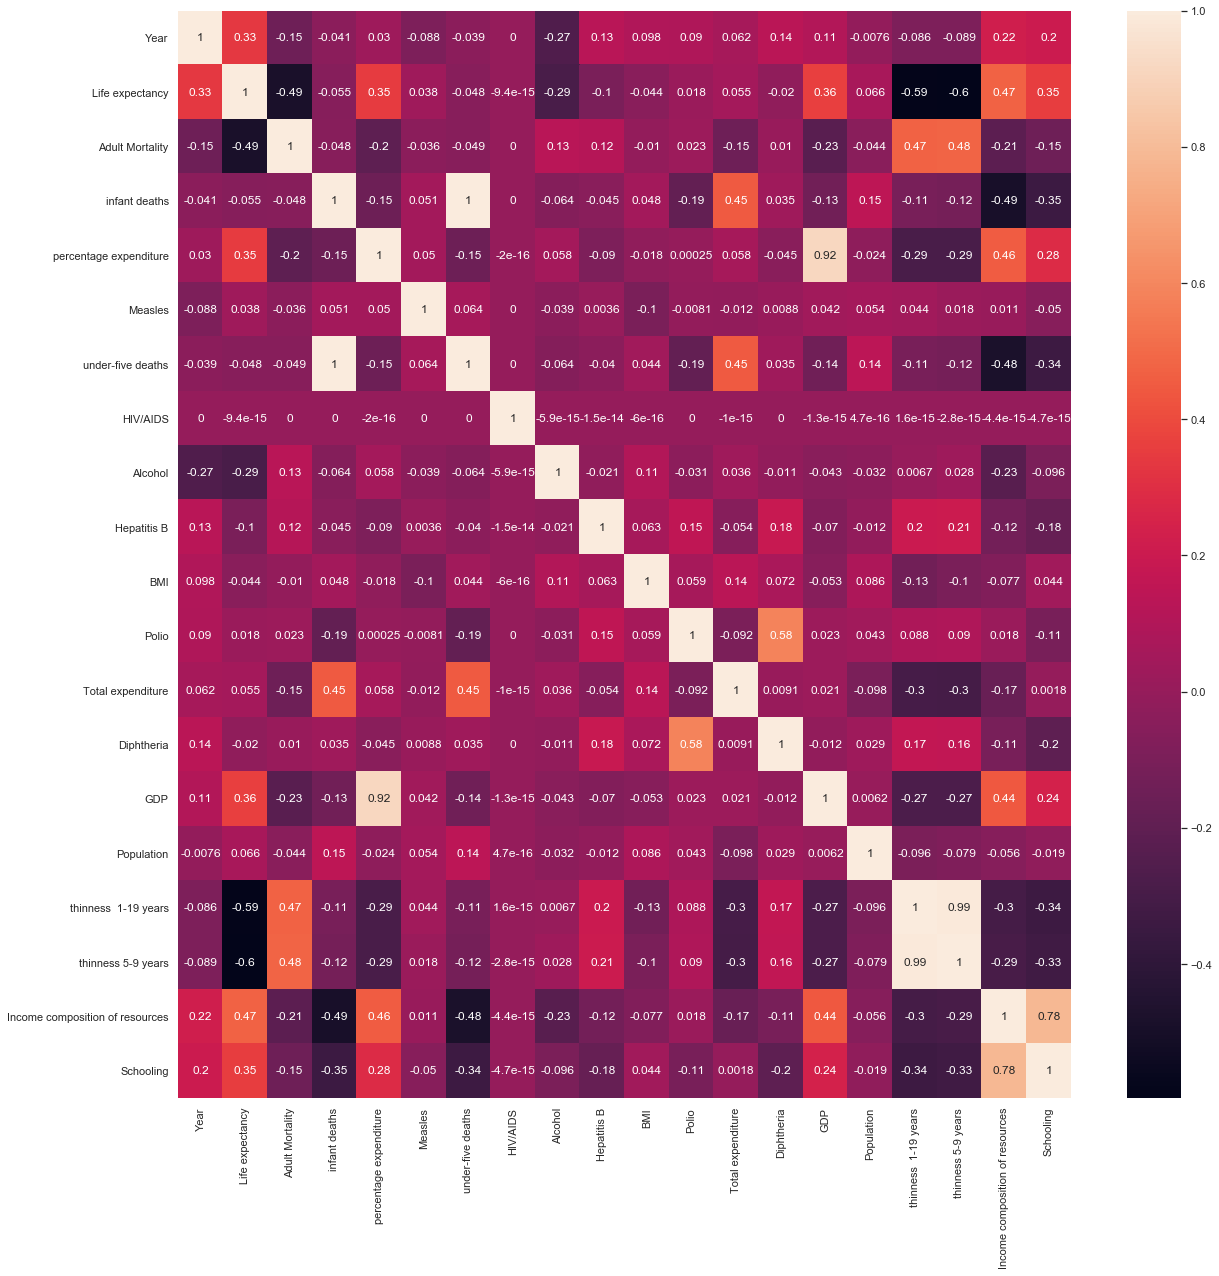

In [36]:
# Correlation matrix of developed countries
sns.set(style='whitegrid')
cfg_figsize = (20, 20)
fig, ax = plt.subplots(figsize=cfg_figsize)
sns.heatmap(df[df['Status']=='Developed'].corr(), annot=True)

In [37]:
# How many unique countries per status?
df.groupby(['Status']).agg({'Country':'nunique'})

,Country
Status,
Developed,32
Developing,151


In [42]:
# Some comparisons between 'Developing' and 'Develop' countries
df_t = df.groupby(['Status']).agg({'Life expectancy': 'mean', 'Adult Mortality':'mean', 'infant deaths':'mean', 'Total expenditure':'mean'}).transpose()
df_t['Status_diff'] = df_t['Developed'] - df_t['Developing']
df_t.style.bar(subset=['Status_diff'], align='mid', color=['#d65f5f', '#5fba7d'])

Status,Developed,Developing,Status_diff
Life expectancy,79.197852,67.111465,12.086386
Adult Mortality,79.685547,182.833195,-103.147648
infant deaths,1.494141,36.534768,-35.040628
Total expenditure,7.452549,5.607538,1.845011


### Life expectancy

Status Life expectancy                                         
                          std        var       mean median q0.25 q0.75
0   Developed        3.930942  15.452305  79.197852  79.25  76.8  81.7
1  Developing        9.006092  81.109695  67.111465  69.00  61.1  74.0

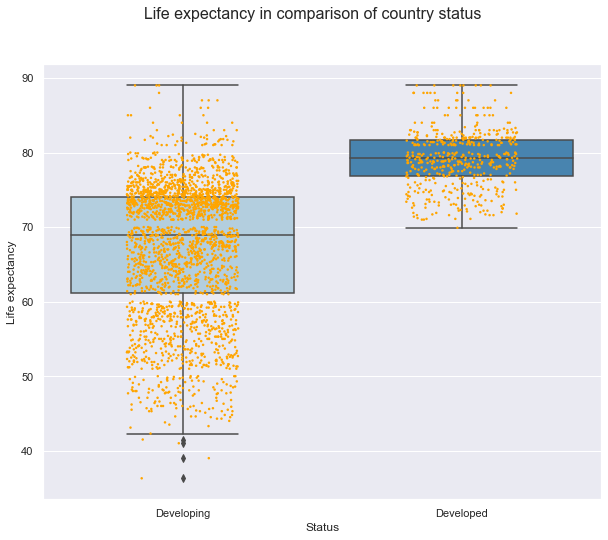

In [44]:
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Life expectancy in comparison of country status', fontsize=16)
sns.boxplot(x='Status', y='Life expectancy', data=df, palette='Blues')
sns.stripplot(x='Status', y='Life expectancy', data=df, color='orange', jitter=0.2, size=2.5)

f = {'Life expectancy':['std','var', 'mean', 'median', quantile_at(0.25), quantile_at(0.75)]}
df.groupby(['Status']).agg(f).reset_index()

Life expectancy over years

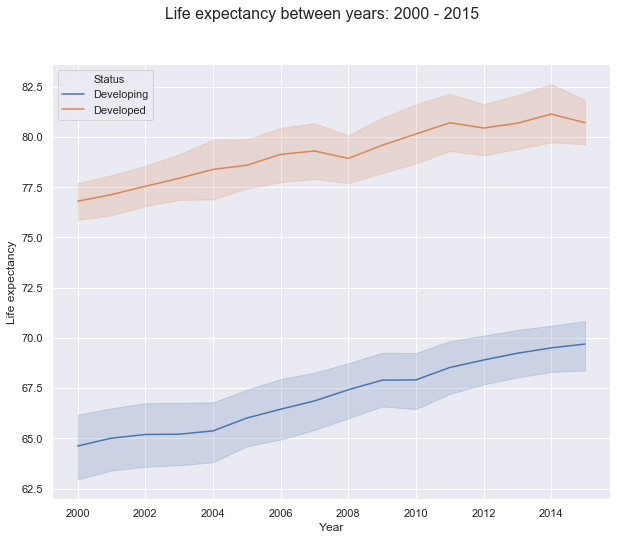

In [45]:
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Life expectancy between years: 2000 - 2015', fontsize=16)
sns.lineplot(x='Year', y='Life expectancy', hue='Status', data=df)

In [49]:
# Looking at the change within life expectancy between 2000 & 2015
df_t = df[df['Year'].isin([2000,2015])].sort_values(by=['Country', 'Year'])[['Country','Status','Year','Life expectancy']].reset_index().drop('index', axis=1).join(
    df[df['Year'].isin([2000,2015])].sort_values(by=['Country', 'Year'])[['Country','Status','Year','Life expectancy']].reset_index().drop('index', axis=1).groupby(['Status','Country'])['Life expectancy'].shift(1).reset_index().rename(columns={'Life expectancy':'Life expectancy_2000'}).drop('index', axis=1))

df_t['RN'] = df_t.sort_values(['Country', 'Year'], ascending=[True,False]).groupby(['Country']).cumcount() + 1
df_t = df_t[df_t['RN']==1].drop(['Year','RN'], axis=1).rename(columns={'Life expectancy':'Life expectancy_2015'})
df_t = df_t[['Country','Status','Life expectancy_2000','Life expectancy_2015']]
df_t['Life expectancy_diff'] = df_t['Life expectancy_2015'] - df_t['Life expectancy_2000']
df_t.groupby(['Status']).agg({'Life expectancy_diff':['mean','min','max','var','std']})

Life expectancy_diff                                
                           mean  min   max        var       std
Status                                                         
Developed              3.906250 -2.0  12.0   4.921895  2.218534
Developing             5.070199 -8.1  21.0  20.501173  4.527822

In [50]:
# Countries with decreasing life expectancy
df_t[df_t['Life expectancy_diff']<0]
# --> conclusion: Data is hardly faulty! Many countries (especially Italy and Sweden) did not decrease their life expectancy between 2005 and 2015!

,Country,Status,Life expectancy_2000,Life expectancy_2015,Life expectancy_diff
109,Estonia,Developing,78.0,77.6,-0.4
131,Grenada,Developing,74.0,73.6,-0.4
155,Iraq,Developing,70.0,68.9,-1.1
189,Libya,Developing,78.0,72.7,-5.3
249,Paraguay,Developing,79.0,74.0,-5.0
265,Romania,Developed,77.0,75.0,-2.0
273,Saint Vincent and the Grenadines,Developing,79.0,73.2,-5.8
317,Syrian Arab Republic,Developing,72.6,64.5,-8.1
361,Yemen,Developing,68.0,65.7,-2.3


In [47]:
# Looking at the life expectancy (fuzzy start & end year reqiured, due to poor data quality!)
df_t = df[df['Year'].isin([2000,2001,2002,2003])].groupby(['Country','Status']).agg({'Life expectancy':'min'}).rename(columns={'Life expectancy':'Life expectancy_2000'}).join(
    df[df['Year'].isin([2013,2014,2015])].groupby(['Country','Status']).agg({'Life expectancy':'max'}).rename(columns={'Life expectancy':'Life expectancy_2015'})).reset_index()
df_t['Life expectancy_diff'] = df_t['Life expectancy_2015'] - df_t['Life expectancy_2000']
#df_t.style.bar(subset=['Life expectancy_diff'], align='mid', color=['#d65f5f', '#5fba7d'])
df_t.groupby(['Status']).agg({'Life expectancy_diff':['mean','min','max','var','std']})

Life expectancy_diff                                
                           mean  min   max        var       std
Status                                                         
Developed              5.065625  2.4  12.4   8.991361  2.998560
Developing             6.105298 -8.1  22.5  22.477438  4.741038

In [48]:
# Countries with decreasing life expectancy
df_t[df_t['Life expectancy_diff']<0]

,Country,Status,Life expectancy_2000,Life expectancy_2015,Life expectancy_diff
158,Syrian Arab Republic,Developing,72.6,64.5,-8.1


### Immunization & Life expectancy

In [51]:
# Creating a summarizing 'immunization feature' cointaining all 3 tpyes of immunizations
df_mean['immunization_overall_mean'] = (df_mean['Diphtheria_mean'] + df_mean['Hepatitis B_mean'] + df_mean['Polio_mean']) / 3

f = {'immunization_overall_mean':['std','var', 'mean', 'median', quantile_at(0.25), quantile_at(0.75)]}
df_mean.groupby(['Status']).agg(f).reset_index()

Status immunization_overall_mean                                    \
                                    std         var       mean     median   
0   Developed                  4.819891   23.231345  90.953923  90.726531   
1  Developing                 14.405117  207.507383  80.034029  82.000000   

                         
       q0.25      q0.75  
0  87.361320  94.520833  
1  70.424636  92.614583

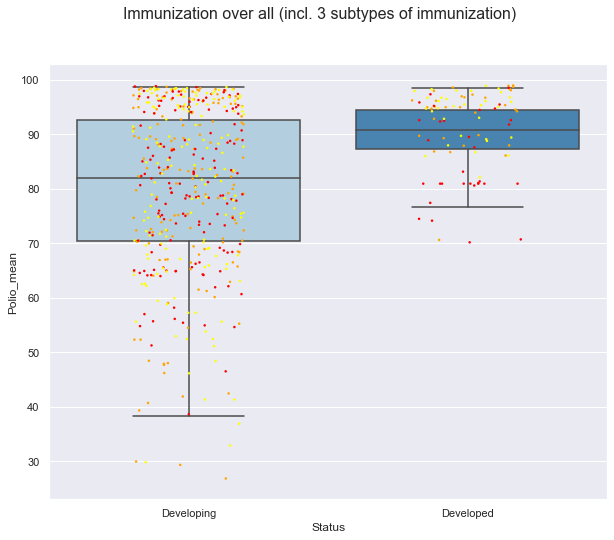

In [54]:
# Immunization overall compared to the 3 types of immunization
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Immunization over all (incl. 3 subtypes of immunization)', fontsize=16)
sns.boxplot(x='Status', y='immunization_overall_mean', data=df_mean, palette='Blues')
sns.stripplot(x='Status', y='Diphtheria_mean', data=df_mean, color='orange', jitter=0.2, size=2.5)
sns.stripplot(x='Status', y='Hepatitis B_mean', data=df_mean, color='red', jitter=0.2, size=2.5)
sns.stripplot(x='Status', y='Polio_mean', data=df_mean, color='yellow', jitter=0.2, size=2.5)

In [55]:
f = {'Diphtheria_mean':['std','var', 'mean', 'median', quantile_at(0.25), quantile_at(0.75)],\
    'Hepatitis B_mean':['std','var', 'mean', 'median', quantile_at(0.25), quantile_at(0.75)],\
    'Polio_mean':['std','var', 'mean', 'median', quantile_at(0.25), quantile_at(0.75)]}
df_mean.groupby(['Status']).agg(f).reset_index()

Status Diphtheria_mean                                          \
                          std         var       mean median     q0.25   
0   Developed        5.768024   33.270098  93.476562   95.0  89.84375   
1  Developing       16.854544  284.075656  79.957412   83.5  70.40625   

             Hepatitis B_mean                                               \
       q0.75              std         var       mean     median      q0.25   
0  97.078125          8.12933   66.085999  85.648878  82.269013  80.960842   
1  94.937500         13.28373  176.457472  79.967351  80.682605  70.183829   

             Polio_mean                                                         
       q0.75        std         var       mean    median      q0.25      q0.75  
0  92.623164   4.474241   20.018834  93.736328  95.28125  89.671875  96.765625  
1  91.748776  16.264739  264.541725  80.177325  83.37500  69.062500  95.093750

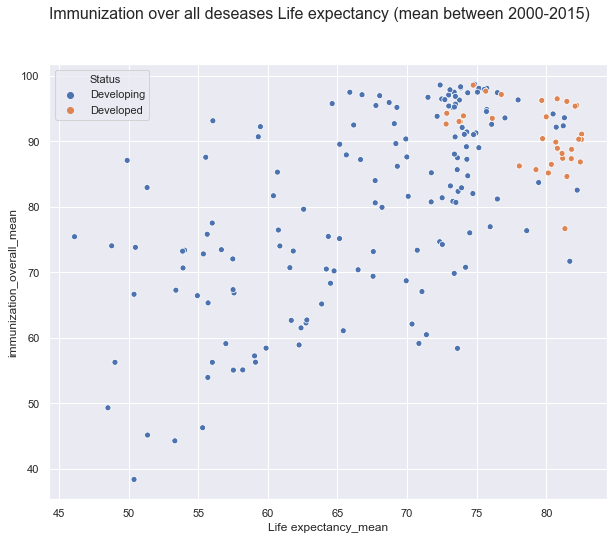

In [56]:
# Immunization mean over all 3 deseases
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Immunization over all deseases Life expectancy (mean between 2000-2015)', fontsize=16)
sns.scatterplot(x='Life expectancy_mean', y='immunization_overall_mean', hue='Status', data=df_mean)

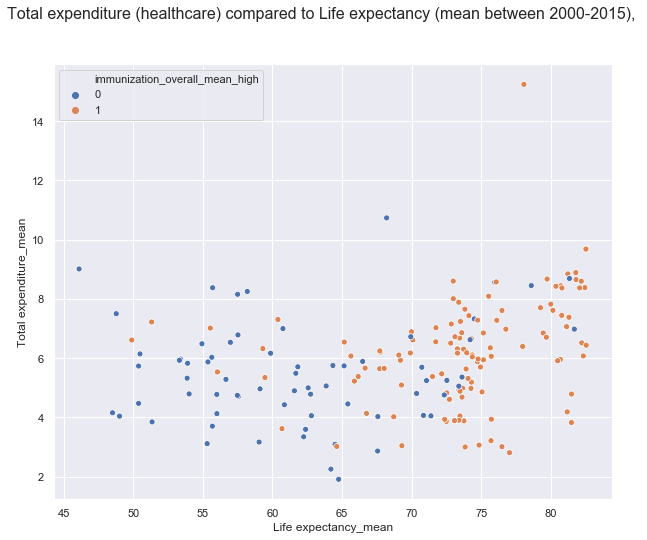

In [57]:
# Let's add a flag for higher/lower immunization coverage and plot again
df_mean['immunization_overall_mean_high'] = df_mean['immunization_overall_mean'].apply(lambda x: 1 if x > 80 else 0)

# Immunization mean over all 3 deseases - but with flag of higher immunization level
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Total expenditure (healthcare) compared to Life expectancy (mean between 2000-2015), ', fontsize=16)
sns.scatterplot(x='Life expectancy_mean', y='Total expenditure_mean', hue='immunization_overall_mean_high', data=df_mean)

In [58]:
# Comparing the immunization and the life expectancy
df_mean['expectancy_mean_65plus'] = df_mean['Life expectancy_mean'].apply(lambda x: 1 if x > 65 else 0)
df_mean.groupby(['expectancy_mean_65plus','immunization_overall_mean_high']).agg({'Total expenditure_mean':['mean','std','var']})

Total expenditure_mean  \
                                                                        mean   
expectancy_mean_65plus immunization_overall_mean_high                          
0                      0                                            5.227625   
                       1                                            5.779246   
1                      0                                            5.972540   
                       1                                            6.239056   

                                                                           
                                                            std       var  
expectancy_mean_65plus immunization_overall_mean_high                      
0                      0                               1.578766  2.492501  
                       1                               1.558735  2.429653  
1                      0                               1.890109  3.572511  
                       1                               1.790282  3.205110

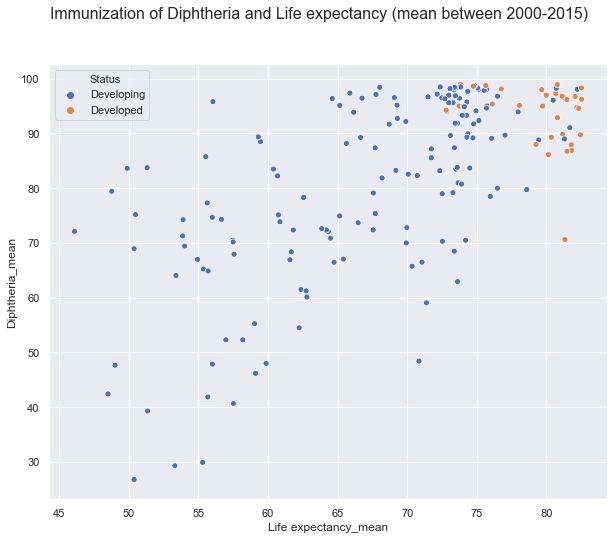

In [59]:
# Detailed view on immunization for Diphtheria
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Immunization of Diphtheria and Life expectancy (mean between 2000-2015)', fontsize=16)
sns.scatterplot(x='Life expectancy_mean', y='Diphtheria_mean', hue='Status', data=df_mean)

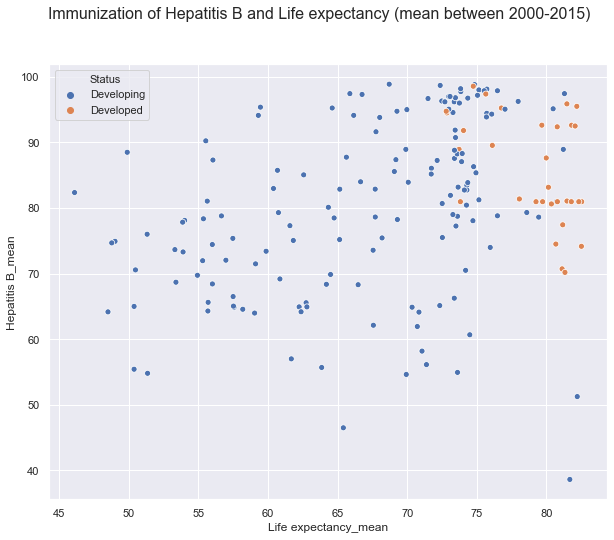

In [60]:
# Detailed view on immunization for Hpatitis B
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Immunization of Hepatitis B and Life expectancy (mean between 2000-2015)', fontsize=16)
sns.scatterplot(x='Life expectancy_mean', y='Hepatitis B_mean', hue='Status', data=df_mean)

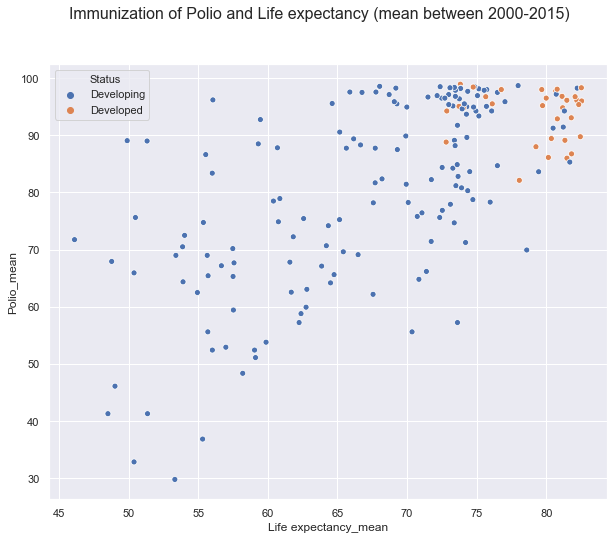

In [61]:
# Detailed view on immunization for Polio
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Immunization of Polio and Life expectancy (mean between 2000-2015)', fontsize=16)
sns.scatterplot(x='Life expectancy_mean', y='Polio_mean', hue='Status', data=df_mean)

### Mortality rates

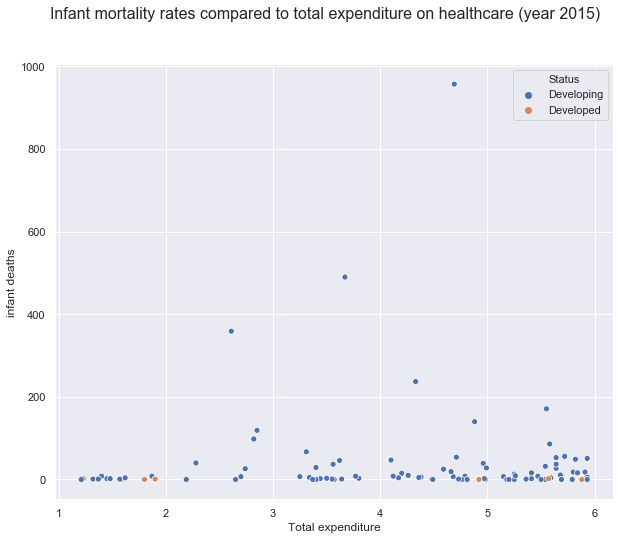

In [63]:
# Mortality rate of infants compared to total expenditure
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Infant mortality rates compared to total expenditure on healthcare (year 2015)', fontsize=16)
sns.scatterplot(x='Total expenditure', y='infant deaths', hue='Status', data=df[(df['Year']==2014) & (df['Total expenditure']<6)])

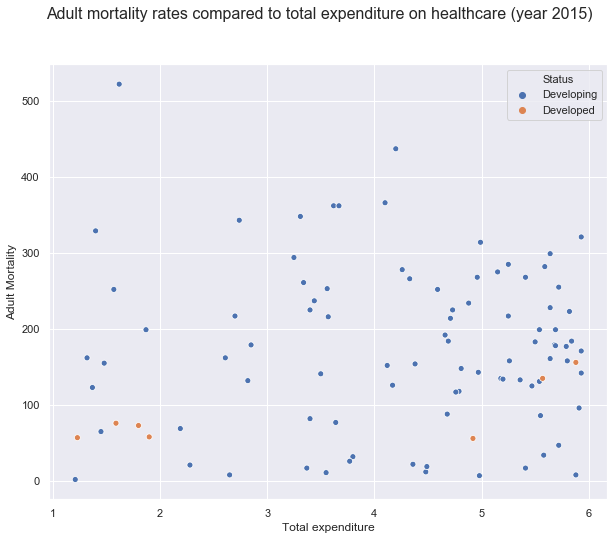

In [65]:
# Mortality rate of adults compared to total expenditure
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Adult mortality rates compared to total expenditure on healthcare (year 2015)', fontsize=16)
sns.scatterplot(x='Total expenditure', y='Adult Mortality', hue='Status', data=df[(df['Year']==2014) & (df['Total expenditure']<6)])

#### Mortality rate vs. total expenditure

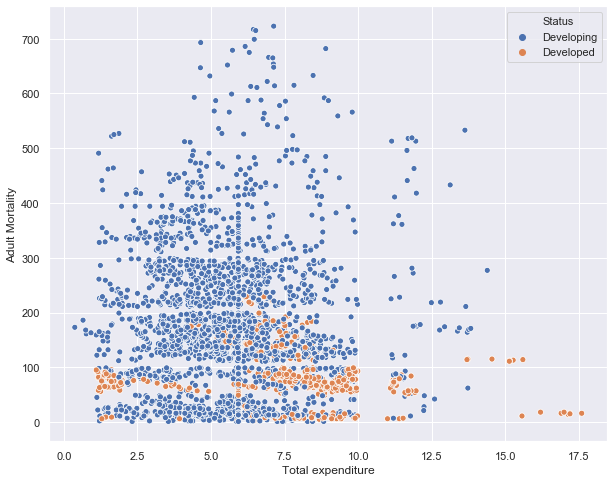

In [67]:
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
sns.scatterplot(x='Total expenditure', y='Adult Mortality', hue='Status', data=df)
#print('percentiles in comparison to', df.groupby(['Status'])['Adult Mortality'].quantile([0.25, 0.5, 0.75]))

#### Calculate mean over time window

In [68]:
df_mean.head()

,Country,Status,Life expectancy_mean,Adult Mortality_mean,infant deaths_mean,percentage expenditure_mean,Measles_mean,under-five deaths_mean,HIV/AIDS_mean,Alcohol_mean,...,Diphtheria_mean,GDP_mean,Population_mean,thinness 1-19 years_mean,thinness 5-9 years_mean,Income composition of resources_mean,Schooling_mean,immunization_overall_mean,immunization_overall_mean_high,expectancy_mean_65plus
0,Afghanistan,Developing,58.19375,269.0625,78.2500,34.960110,2362.2500,107.5625,0.10000,0.014375,...,52.3125,340.015425,9.972260e+06,16.58125,15.58125,0.415375,8.21250,55.083333,0,0
1,Albania,Developing,75.15625,45.0625,0.6875,193.259091,53.3750,0.9375,0.10000,4.848750,...,98.0625,2119.726679,6.969116e+05,1.61875,1.70000,0.709875,12.13750,98.062500,1,1
2,Algeria,Developing,73.61875,108.1875,20.3125,236.185241,1943.8750,23.5000,0.10000,0.669678,...,91.8750,2847.853392,2.164983e+07,6.09375,5.97500,0.694875,12.71250,87.455070,1,1
3,Angola,Developing,49.01875,328.5625,83.7500,102.100268,3561.3125,132.6250,2.36875,5.670303,...,47.6875,1975.143045,1.014710e+07,6.19375,6.66875,0.458375,8.04375,56.244289,0,0
4,Antigua and Barbuda,Developing,75.05625,127.5000,0.0000,1001.585226,0.0000,0.0000,0.12500,7.740928,...,98.3125,9759.305728,1.276454e+07,3.42500,3.37500,0.488625,8.84375,97.478351,1,1


,Country,Status,Life expectancy_mean,Adult Mortality_mean,infant deaths_mean,percentage expenditure_mean,Measles_mean,under-five deaths_mean,HIV/AIDS_mean,Alcohol_mean,...,Diphtheria_mean,GDP_mean,Population_mean,thinness 1-19 years_mean,thinness 5-9 years_mean,Income composition of resources_mean,Schooling_mean,immunization_overall_mean,immunization_overall_mean_high,expectancy_mean_65plus
21,Botswana,Developing,56.05000,448.1250,2.0000,334.266971,237.8750,3.1250,16.52500,4.666553,...,95.8125,4498.285431,1.063867e+06,7.43750,7.81250,0.630375,12.137500,93.104167,1,0
43,Côte d'Ivoire,Developing,50.38750,417.3125,61.5000,0.000000,1708.2500,86.8125,4.68750,2.948428,...,68.9375,7494.210719,1.276454e+07,6.73750,6.69375,0.627419,11.999639,66.624184,0,0
92,Lesotho,Developing,48.78125,550.0625,4.5000,82.118913,266.6875,6.3125,22.96875,2.244678,...,79.4375,794.523010,1.200528e+06,7.18750,7.06875,0.456813,10.656250,74.018386,0,0
98,Malawi,Developing,49.89375,424.4375,37.1250,25.849706,7559.4375,58.7500,16.68125,1.150303,...,83.6250,237.504042,6.700263e+06,7.11875,6.98750,0.410625,10.231250,87.060868,1,0
149,South Africa,Developing,57.50000,412.7500,48.6875,616.359644,1506.0000,69.8125,18.49375,7.402803,...,70.1875,4869.427044,2.921384e+07,9.17500,11.07500,0.629062,12.893750,67.333333,0,0
182,Zimbabwe,Developing,50.48750,462.3750,26.5625,20.364271,923.0000,40.8125,23.26250,4.490303,...,75.1875,410.980194,8.021343e+06,7.01250,6.98750,0.439125,9.825000,73.791667,0,0


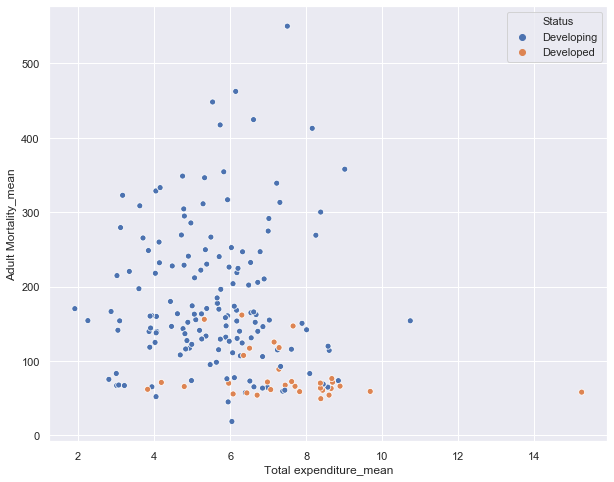

In [70]:
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
sns.scatterplot(x='Total expenditure_mean', y='Adult Mortality_mean', hue='Status', data=df_mean)

# investiage those high numbers
df_mean[df_mean['Adult Mortality_mean'] > 400]

54

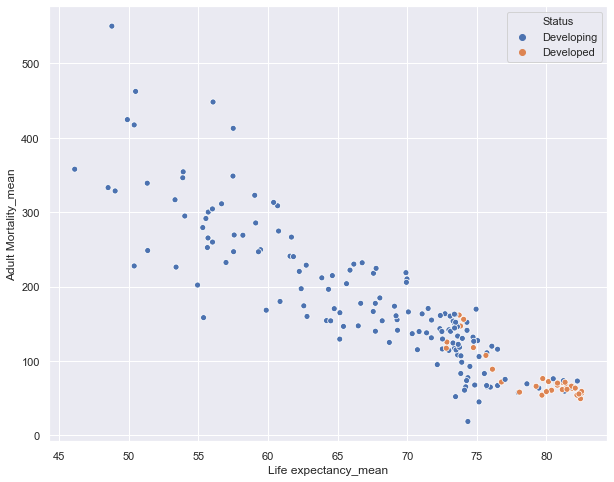

In [71]:
# Adult Mortality & Life expectancy
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
sns.scatterplot(x='Life expectancy_mean', y='Adult Mortality_mean', hue='Status', data=df_mean)

# investigating further
df_mean[(df_mean['Life expectancy_mean']>73) & (df_mean['Status']=='Developing')].shape[0]

54

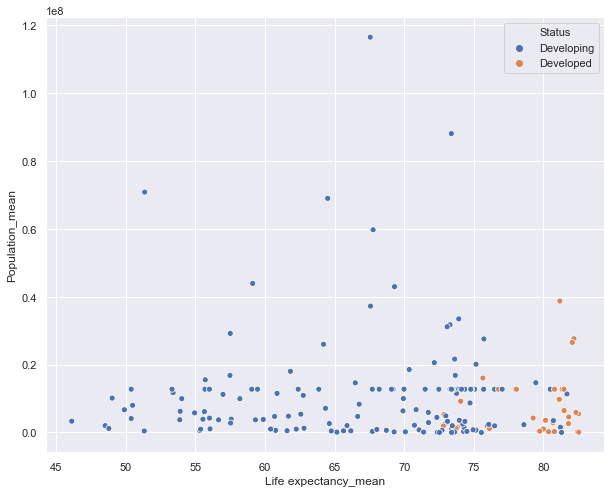

In [73]:
# Life expectancy & Population
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
sns.scatterplot(x='Life expectancy_mean', y='Population_mean', hue='Status', data=df_mean[df_mean['Population_mean']<400000000])


# investigating further
df_mean[(df_mean['Life expectancy_mean']>73) & (df_mean['Status']=='Developing')].shape[0]

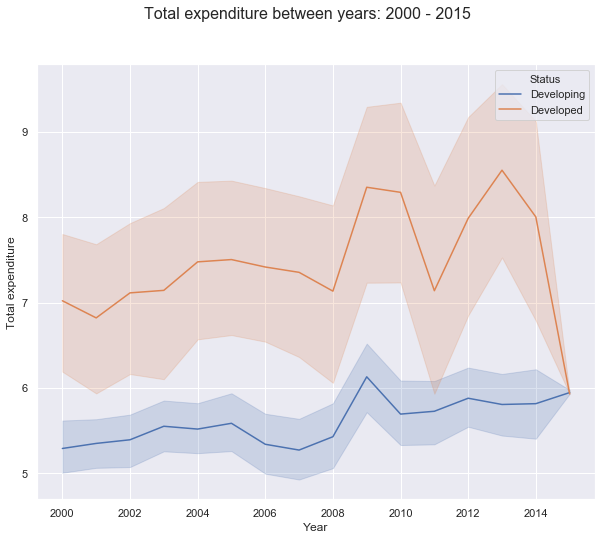

In [74]:
# Exploring the total expenditure
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Total expenditure between years: 2000 - 2015', fontsize=16)
sns.lineplot(x='Year', y='Total expenditure', hue='Status', data=df)

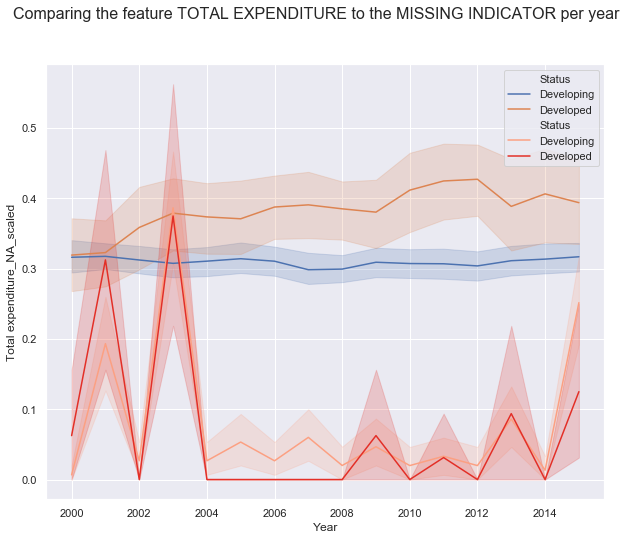

In [75]:
# Checking if might be an issue with the missing imputation --> comparing the values of the selected feature to the sum of missings of this feature per year
df_t = df.copy()
cols_matching = [k for k in df_t.columns.tolist() if '_NA' in k]

for i in cols_matching:
    df_t[i] = df_t[i].astype(str)
    df_t[i] = df_t[i].str.replace('True', '1')
    df_t[i] = df_t[i].str.replace('False', '0')
    df_t[i] = df_t[i].str.replace('nan', '0')
    df_t[i] = df_t[i].astype(int)
    
from sklearn import preprocessing

#['Total expenditure', 'Total expenditure_NA']
x = df_t[['Total expenditure', 'Total expenditure_NA']].values
cols_normalize = df_t.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns=['Total expenditure_scaled', 'Total expenditure_NA_scaled'])

# plot the comparison
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Comparing the feature TOTAL EXPENDITURE to the MISSING INDICATOR per year', fontsize=16)
sns.lineplot(x='Year', y='Total expenditure_scaled', hue='Status', data=df_t.join(df_scaled))
sns.lineplot(x='Year', y='Total expenditure_NA_scaled', hue='Status', data=df_t.join(df_scaled), palette='Reds')

In [76]:
# Shift / lag function to provide a distribution
df_t = df[['Country','Year', 'Status', 'Total expenditure']].join(df.sort_values(by=['Country','Year']).groupby(['Status', 'Country'])['Total expenditure'].shift(1).reset_index().rename(columns={'Total expenditure':'Total expenditure_shift1'}).set_index('index'))
df_t['Total expenditure_diff'] = df_t['Total expenditure'] - df_t['Total expenditure_shift1']
df_t['Total expenditure_diff_abs'] = df_t['Total expenditure_diff'].apply(lambda x: np.abs(x))
df_t.head()
#df_t.style.bar(subset=['Total expenditure_diff'], align='mid', color=['#d65f5f', '#5fba7d'])

,Country,Year,Status,Total expenditure,Total expenditure_shift1,Total expenditure_diff,Total expenditure_diff_abs
0,Afghanistan,2015,Developing,8.16,8.18,-0.02,0.02
1,Afghanistan,2014,Developing,8.18,8.13,0.05,0.05
2,Afghanistan,2013,Developing,8.13,8.52,-0.39,0.39
3,Afghanistan,2012,Developing,8.52,7.87,0.65,0.65
4,Afghanistan,2011,Developing,7.87,9.20,-1.33,1.33


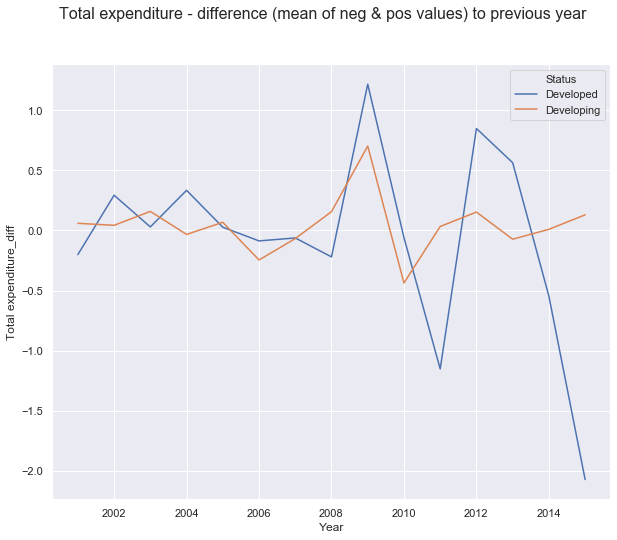

In [77]:
# Visualization of table from cell above
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Total expenditure - difference (mean of neg & pos values) to previous year', fontsize=16)
sns.lineplot(x='Year', y='Total expenditure_diff', hue='Status', data=df_t.groupby(['Status', 'Year']).agg({'Total expenditure_diff':'mean'}).reset_index())

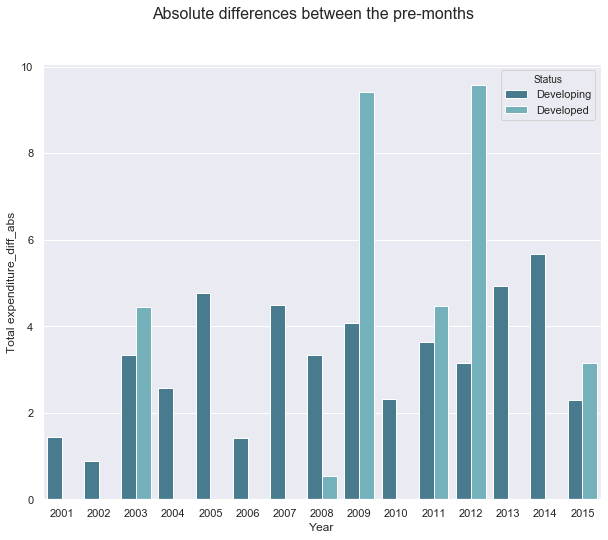

In [78]:
# row_number over to get max value
df_t['RN'] = df_t.sort_values(['Country','Total expenditure_diff_abs'], ascending=[False,False]) \
    .groupby(['Country']).cumcount() + 1 


sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Absolute differences between the pre-months', fontsize=16)
#sns.barplot(x='Year', y='Total expenditure_diff_abs', data=df_t[df_t['RN']==1].groupby(['Year']).agg({'Total expenditure_diff_abs':'mean'}).reset_index(), label="Total", color="b")
sns.barplot(x='Year', y='Total expenditure_diff_abs', hue='Status', data=df_t[df_t['RN']==1].groupby(['Year','Status']).agg({'Total expenditure_diff_abs':'mean'}).reset_index(), palette='GnBu_d')

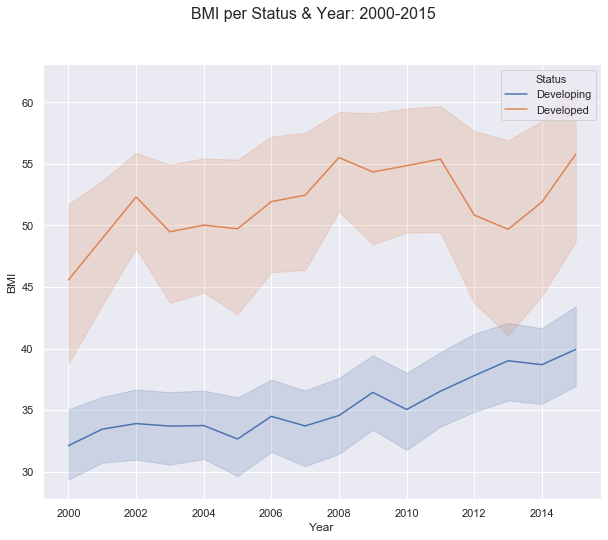

In [80]:
# BMI per Status & Year: 2000-2015
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('BMI per Status & Year: 2000-2015', fontsize=16)
sns.lineplot(x='Year', y='BMI', hue='Status', data=df)

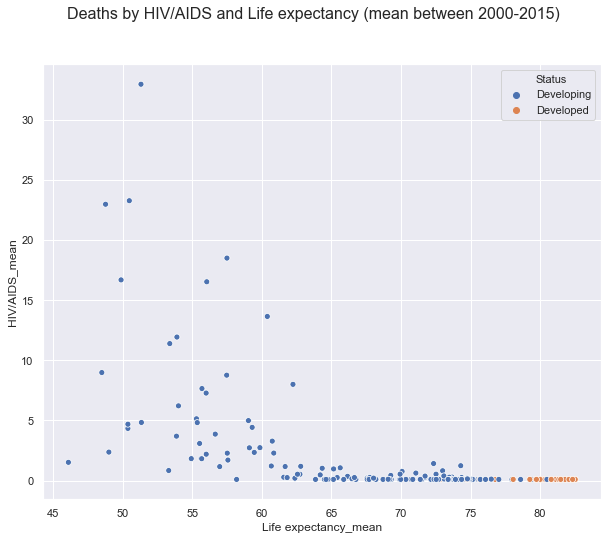

In [81]:
# Immunization for Diphtheria
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Deaths by HIV/AIDS and Life expectancy (mean between 2000-2015)', fontsize=16)
sns.scatterplot(x='Life expectancy_mean', y='HIV/AIDS_mean', hue='Status', data=df_mean)
#print('percentiles in comparison to', df.groupby(['Status'])['Adult Mortality'].quantile([0.25, 0.5, 0.75]))

# ML Models

## Model: **Decision Tree Classifier**
* type: supervised, binary-classification
* predict variable: _Status_

In [82]:
df_mean.columns

Index(['Country', 'Status', 'Life expectancy_mean', 'Adult Mortality_mean',
       'infant deaths_mean', 'percentage expenditure_mean', 'Measles_mean',
       'under-five deaths_mean', 'HIV/AIDS_mean', 'Alcohol_mean',
       'Hepatitis B_mean', 'BMI_mean', 'Polio_mean', 'Total expenditure_mean',
       'Diphtheria_mean', 'GDP_mean', 'Population_mean',
       'thinness  1-19 years_mean', 'thinness 5-9 years_mean',
       'Income composition of resources_mean', 'Schooling_mean',
       'immunization_overall_mean', 'immunization_overall_mean_high',
       'expectancy_mean_65plus'],
      dtype='object')

In [83]:
cols_feature = ['Adult Mortality_mean', 'infant deaths_mean', 'percentage expenditure_mean', 'Measles_mean', 'under-five deaths_mean', 'HIV/AIDS_mean',  'Alcohol_mean', 'Hepatitis B_mean', 'BMI_mean', 'Polio_mean', 'Total expenditure_mean', 'Diphtheria_mean', 'GDP_mean', 'Population_mean', 'thinness  1-19 years_mean', 'thinness 5-9 years_mean', 'Income composition of resources_mean', 'Schooling_mean']
X = df_mean[cols_feature]
y = df_mean['Status'].replace({'Developing':'0','Developed':'1'})


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Initiate model
clf = DecisionTreeClassifier()

# Fitting the model
clf = clf.fit(X_train, y_train)

# Prediction for test data
y_pred = clf.predict(X_test)

# Evaluate the model
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('ROC AUC score:', metrics.roc_auc_score(y_test, y_pred))
print('Recall score:', metrics.recall_score(y_test, y_pred, pos_label='1'))
#print('t', metrics.precision_recall_fscore_support(y_test, y_pred))

Accuracy: 0.8181818181818182
ROC AUC score: 0.6663763066202091
Recall score: 0.35714285714285715


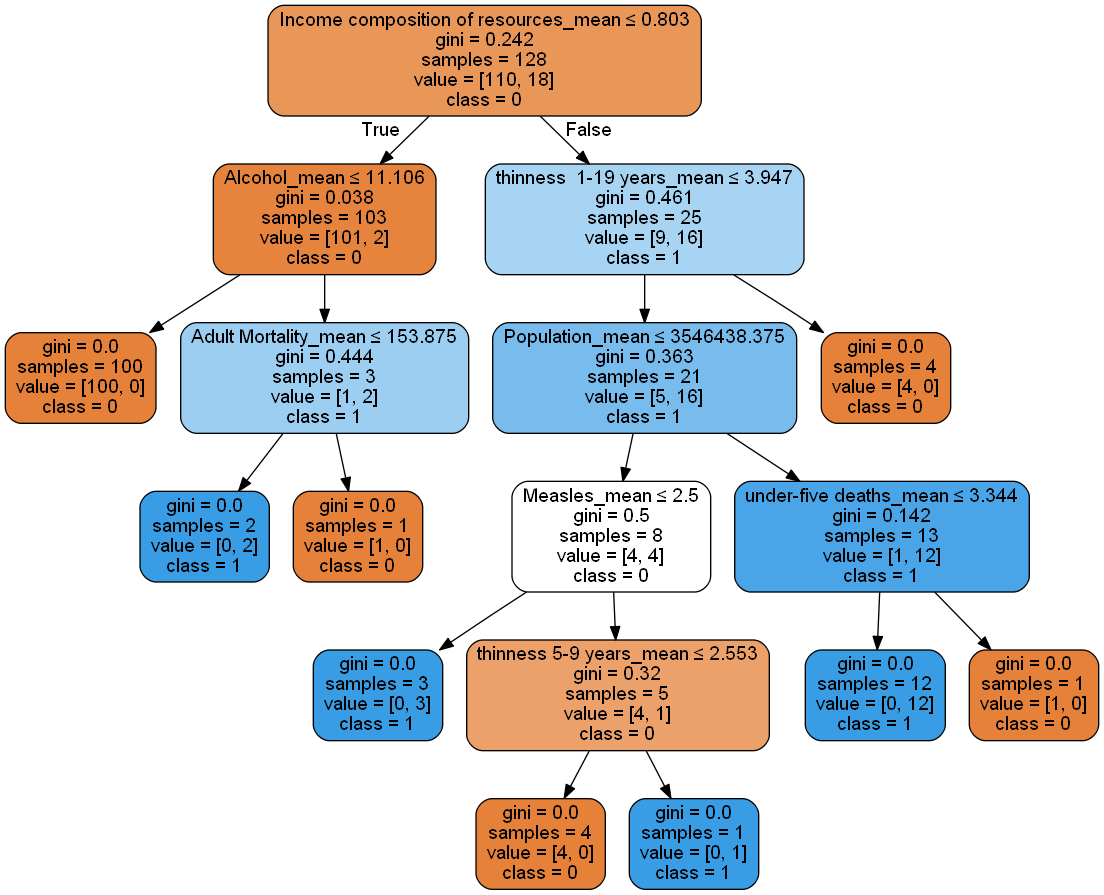

In [85]:
# Export Decision Tree

# Fix for missing Graphviz system path & requirements --> https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/info/.conda/graphviz/bin'

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = cols_feature, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('data_out/model_dtc_status.png')
Image(graph.create_png())

## Model: **Linear Regression**
* type: supervised, continuous
* predict variable: _Life expactancy_

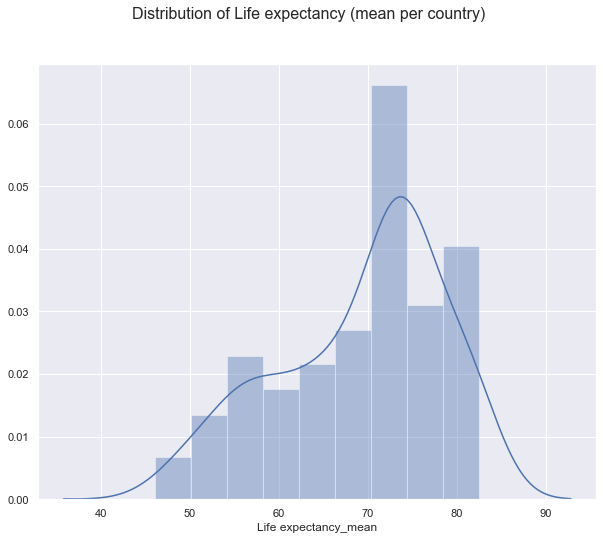

In [86]:
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Distribution of Life expectancy (mean per country)', fontsize=16)
sns.distplot(df_mean['Life expectancy_mean'])

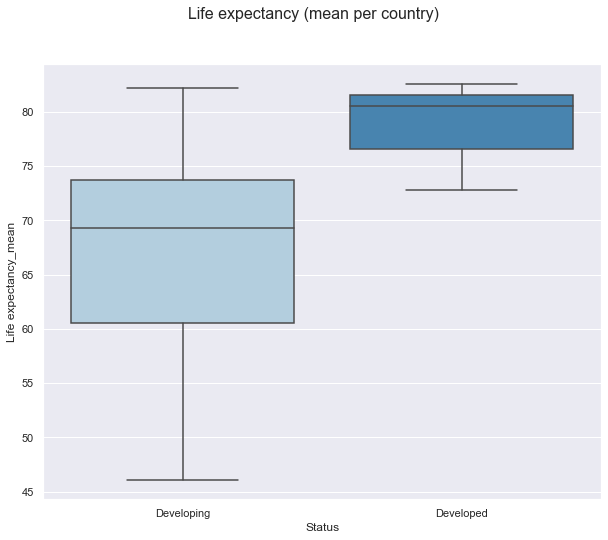

In [87]:
sns.set(style='darkgrid')
cfg_figsize = (10, 8)
fig, ax = plt.subplots(figsize=cfg_figsize)
fig.suptitle('Life expectancy (mean per country)', fontsize=16)
sns.boxplot(x='Status', y='Life expectancy_mean', data=df_mean, palette='Blues')

In [88]:
cols_feature = ['Adult Mortality_mean', 'infant deaths_mean', 'percentage expenditure_mean', 'Measles_mean', 'under-five deaths_mean', 'HIV/AIDS_mean',  'Alcohol_mean', 'Hepatitis B_mean', 'BMI_mean', 'Polio_mean', 'Total expenditure_mean', 'Diphtheria_mean', 'GDP_mean', 'Population_mean', 'thinness  1-19 years_mean', 'thinness 5-9 years_mean', 'Income composition of resources_mean', 'Schooling_mean']
X = df_mean[cols_feature]
y = df_mean['Life expectancy_mean']

In [89]:
# Train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [90]:
# Standardisation for Linear Regression Model
scaler = StandardScaler()

# fitting train, test data
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.fit_transform(X_test)

In [91]:
# Linear Regression

# Instantiate model
model_lr = LinearRegression()

# Train model
model_lr.fit(train_scaled, y_train)

# Predict target
y_train_pred = model_lr.predict(train_scaled)
y_test_pred = model_lr.predict(test_scaled)

In [92]:
# Evaluation metrics
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print('Model evaluation on train data')
print('\tmse:', mse_train, '\n\tmae:', mae_train, '\n\trmse:', sqrt(mse_train))

print('Model evaluation on test data')
print('\tmse:', mse_test, '\n\tmae:', mae_test, '\n\trmse:', sqrt(mse_test))


print('Due to comparison of rmse for train & test dataset the model tends to be:', ('overfitting' if sqrt(mse_test)> sqrt(mse_train) else 'underfitting'))

Model evaluation on train data
	mse: 5.15306883472175 
	mae: 1.8164499103968574 
	rmse: 2.270037187960089
Model evaluation on test data
	mse: 10.057015560393758 
	mae: 2.3625591825703025 
	rmse: 3.1712797985030834
Due to comparison of rmse for train & test dataset the model tends to be: overfitting
